## Deriving Insights from Student Academic Data Using K-Means

In unsupervised learning, data is grouped without predefined labels, aiming for high similarity within groups and differences between them, which can help categorize students with similar needs in education. K-means, a widely used clustering method, necessitates specifying cluster count beforehand and uses centroids for data grouping. The algorithm involves repeatedly recalculating centroids by averaging cluster data points until stabilization. Determining the optimal cluster number in k-means can be achieved through methods like scree plots, which compare cluster counts to within-group variances. Ultimately, the practical utility of clusters, beyond their statistical attributes, dictates their significance.


<div align="center">
<img src="https://d3i6fh83elv35t.cloudfront.net/static/2023/07/learning-1-1024x683.jpg" width="500" height="300"/>


source: PBS
</div>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans

More on k-means:
(https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

We might already have an idea of how many groups we want, based on our needs. For instance, if a data team wants three groups for customer targeting, we can make those three groups. But these groups might not be the best fit based on the data.

There are a few ways we can measure the cluster quality - average silhoutte, PCA (simplfies complex data) or the elbow method to name a few. For this notebook, we will be using the elbow method due to its easy to understand and visual nature. The 'elbow' will show us the point where adding more groups doesn't necessarily benefit our analysis anymore.

A thing to remember: the k-means method can sometimes give non-optimal solutions, so it's a good idea to run it multiple times and pick the best result. For our current task, we've fixed the method to give consistent results for easier learning.

The data is sourced from Open University (https://analyse.kmi.open.ac.uk/open_dataset)

In [3]:
# Read files
lr = pd.read_csv('/content/learningResource.csv')
qt = pd.read_csv('/content/testScores.csv')
si = pd.read_csv('/content/studentInfo.csv')

In [20]:
lr.head()

,id_student,activity_type,activity_id,date,sum_click
0,420388,resource,219,0,1
1,420388,course_homepage,1,0,3
2,420388,course_page,87,0,1
3,420388,resource,229,0,2
4,420388,course_page,1,0,2


In [19]:
qt.head()

,id_student,assignment_name,due_date,weight,date_submitted,score
0,41060,Quiz 1,23,2.0,25.0,77
1,41060,Test 1,25,7.5,24.0,85
2,41060,Quiz 2,51,3.0,54.0,94
3,41060,Test 2,53,10.0,53.0,86
4,41060,Quiz 3,79,3.0,81.0,94


### Data Cleaning
Data cleaning is an essential part of any proper modeling. This particular dataset is a subset of a much larger and complex dataset that has been trimmed and cleaned for a specific subject (separate notebook). It is important to note that domain knowledge played a big role here.

As a simpler demonstration, we can see below that we have student submission NaNs. Let's take a closer look.

In [22]:
# si.isnull().sum()

In [23]:
qt.isnull().sum()

id_student            0
assignment_name       0
due_date              0
weight                0
date_submitted     2202
score                 0
dtype: int64

In [27]:
no_submission_qt = qt[qt['date_submitted'].isna()]
no_submission_qt['score'].max()

0

In this case, it is safe to assume that the date_submitted nan values are 'not submitted' in the domain context. We can observe that the score is 0. There are a few strategies. I'd like to avoid the common strategy of filling with zero and skewing the model. We have a relatively significant numbers of non-submissions and since they are implied to academic performance, dropping them is not a great solution either.

There are two solutions that come to mind:

1) match it to the due date + 1, thus keeping 0 score

2) turn it into a binary column

For now, we will fill it with the due date and possibly review/backfill later. I want to keep the relative time structure.

In [29]:
qt['date_submitted'] = qt.apply(lambda row: row['due_date'] + 1 if pd.isna(row['date_submitted']) else row['date_submitted'], axis=1)


In [32]:
qt.isnull().sum()

id_student         0
assignment_name    0
due_date           0
weight             0
date_submitted     0
score              0
dtype: int64

Our data is in a long form. We will do some data wrangling to make it a wide form. Then, we will prepare our variables for unsupervised learning. It is important that we remove the student_id. We don't want that to be a feature for obvious reasons.

In [33]:
qt_cluster = qt.pivot(index='id_student', columns='assignment_name', values='score').reset_index()

# remove student id
X1 = qt_cluster.iloc[:, 1:]

In [34]:
lr_cluster = lr.groupby(['id_student','activity_id']).agg({'sum_click': 'sum'}).reset_index()
X2 = lr_cluster.drop(columns=['id_student'])


K-means, which calculates the distance, is very sensitive to range of variables. To avoid features with large scales dominating, we will scale our data. Once again, many options but we are using preprocessing.scale today.

In [37]:
# Scale the data
X1 = preprocessing.scale(X1)
X2 = preprocessing.scale(X2)

As mentioned above, identifying the right number of clusters is important. Below, is the elbow method where the cluster quality is visualized.

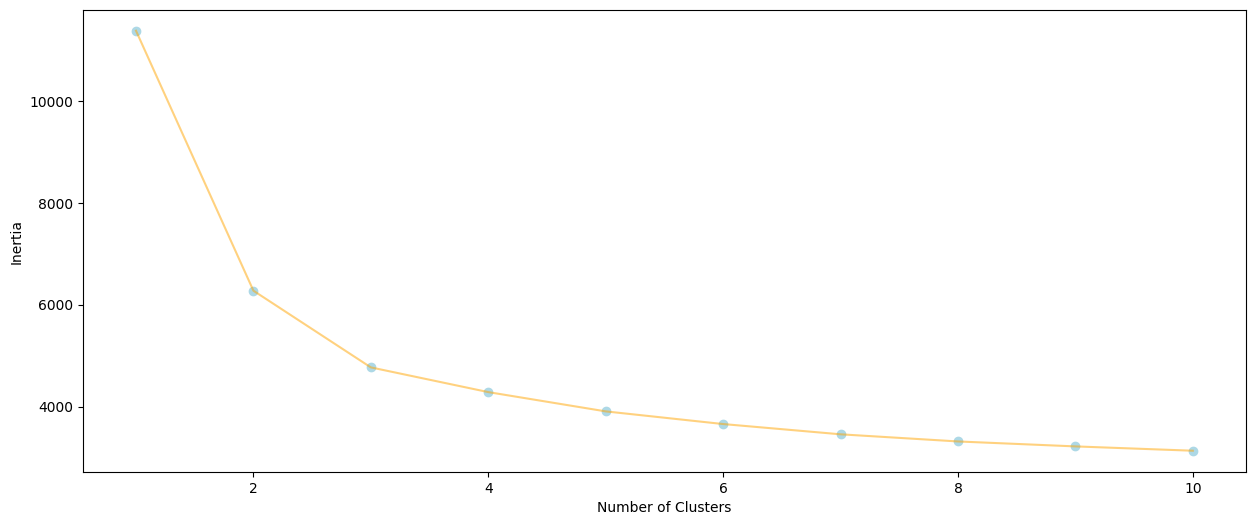

In [148]:
inertia = []
for n in range(1 , 11):
  algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300,
              tol=0.0001,  random_state= 111  , algorithm='lloyd') )

  algorithm.fit(X1)
  inertia.append(algorithm.inertia_)

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o', color='lightblue')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5, color='orange')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

Now for the learning resources

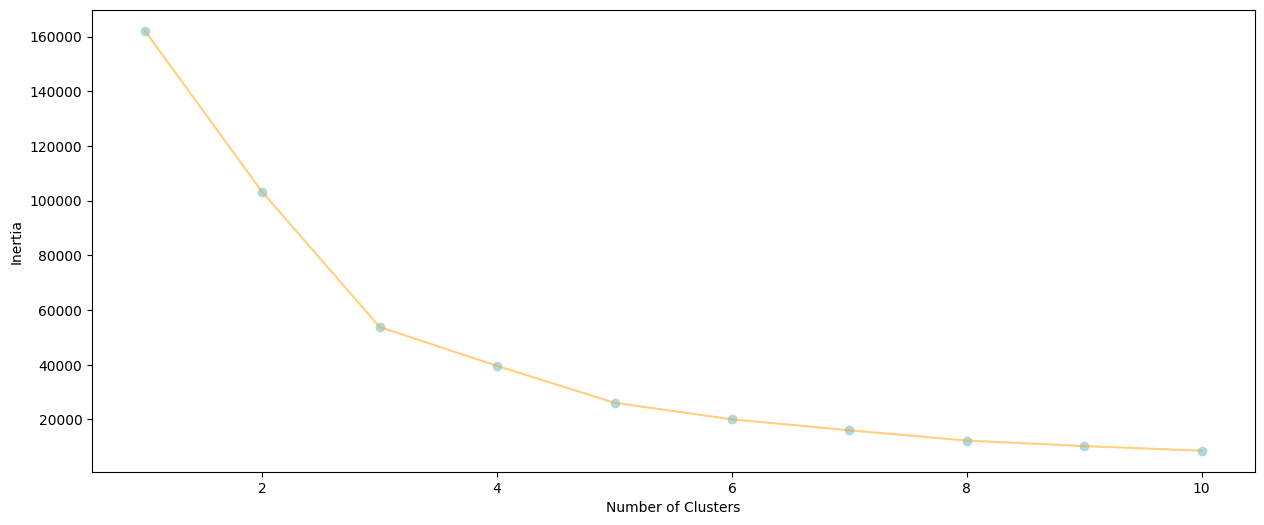

In [149]:
inertia = []
for n in range(1 , 11):
  algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300,
              tol=0.0001,  random_state= 111  , algorithm='lloyd') )

  algorithm.fit(X2)
  inertia.append(algorithm.inertia_)

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o', color='lightblue')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5, color='orange')
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

We can see that for both datasets, 3 clusters is where the 'elbow' is. We will keep 3 for both for now.

In [46]:
# Model training & predictions - test scores
km_qt = KMeans(n_clusters = 3)
km_qt.fit(X1)
qt_pred = km_qt.predict(X1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [47]:
# Model training & predictions - learning resources
km_lr = KMeans(n_clusters = 3)
km_lr.fit(X2)
lr_pred = km_lr.predict(X2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
qt_cluster['cluster'] = pd.Series(qt_pred, index=qt_cluster.index)
lr_cluster['cluster'] = pd.Series(lr_pred, index=lr_cluster.index)

Now we have the clusters assigned to each student. Let's see some descriptive stats.

In [107]:
qt_cluster.groupby(['cluster']).agg(['mean']).round(2).reset_index()

assignment_name,cluster,id_student,Final Exam,Quiz 1,Quiz 2,Quiz 3,Quiz 4,Quiz 5,Quiz 6,Quiz 7,Test 1,Test 2,Test 3,Test 4,Test 5,Test 6
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,0,706501.18,33.47,61.05,75.73,61.42,58.96,50.90,36.74,23.55,70.34,68.29,68.93,49.13,37.76,20.18
1,1,761086.24,64.71,80.04,90.59,84.56,84.65,85.07,76.15,70.08,81.11,82.57,87.42,81.85,73.74,64.41
2,2,711394.19,0.81,44.22,33.28,12.96,5.79,1.93,1.95,0.69,46.33,22.60,11.59,5.50,2.96,1.12


In [50]:
lr_cluster.groupby(['cluster']).agg(['mean']).round(2).reset_index()

,cluster,id_student,activity_id,sum_click
,,mean,mean,mean
0,0,739789.85,65.85,12.02
1,1,731788.37,201.00,2.80
2,2,727554.77,5.40,704.15


### Summary of quizzes/tests data so far:

0: moderate performers

1: high performers

2: low performers

### Summary of learning rate data:

0: moderate engagement/activity

1: high engagement/activity

2: low engagement/activity

We should rename these clusters in a bit, since they are not intuitive yet.

In [108]:
# Merging the learning resources dataframe with test performance dataframe
merged_df = pd.merge(lr_cluster, qt_cluster, on='id_student', how='inner', suffixes=('_lr', '_qt'))

In [109]:
cross_tab = pd.crosstab(merged_df['cluster_lr'], merged_df['cluster_qt'], margins=True, margins_name="Total")
cross_tab

cluster_qt,0,1,2,Total
cluster_lr,,,,
0,21758,29603,4492,55853
1,8860,14176,1575,24611
2,193,406,9,608
Total,30811,44185,6076,81072


In [115]:
# Merging with the rest of the student information - our final, combined dataframe
merged_si = pd.merge(si, merged_df, on='id_student', how='inner')

Just a reminder, there is a pass or fail column in the student information. This is a very important column for obvious reasons.

In [116]:
merged_si['final_result'].unique()

array(['Fail', 'Pass'], dtype=object)

Let's make that column useful by encoding it. I'm going to calculate a passing rate by tying it to the clusters we found earlier and look for any patterns. Lastly, I'm renaming the clusters.

In [137]:
# Create a column indicating 1 for 'Pass' and 0 otherwise in 'final_result'
merged_si['pass_indicator'] = merged_si['final_result'].apply(lambda x: 1 if x == 'Pass' else 0)

# Group by the two clusters and calculate the mean of 'pass_indicator' which gives the pass rate
pass_rate = merged_si.groupby(['cluster_lr', 'cluster_qt']).agg({'pass_indicator': 'mean'}).reset_index()

# Rename the columns for clarity
pass_rate.rename(columns={'pass_indicator': 'pass_rate'}, inplace=True)

# # Renaming clusters based on descriptive stats above
cluster_mapping_qt = {2: 'low', 0: 'moderate', 1: 'high'}
cluster_mapping_lr = {1: 'low', 0: 'moderate', 2: 'high'}

pass_rate['cluster_qt'] = pass_rate['cluster_qt'].map(cluster_mapping_qt)
pass_rate['cluster_lr'] = pass_rate['cluster_lr'].map(cluster_mapping_lr)

pass_rate

,cluster_lr,cluster_qt,pass_rate
0,moderate,moderate,0.529047
1,moderate,high,0.976354
2,moderate,low,0.000000
3,low,moderate,0.548646
4,low,high,0.977497
5,low,low,0.000000
6,high,moderate,0.554404
7,high,high,0.965517
8,high,low,0.000000


<ipython-input-146-712e1bb38628>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = pass_rate.pivot('cluster_lr', 'cluster_qt', 'pass_rate')


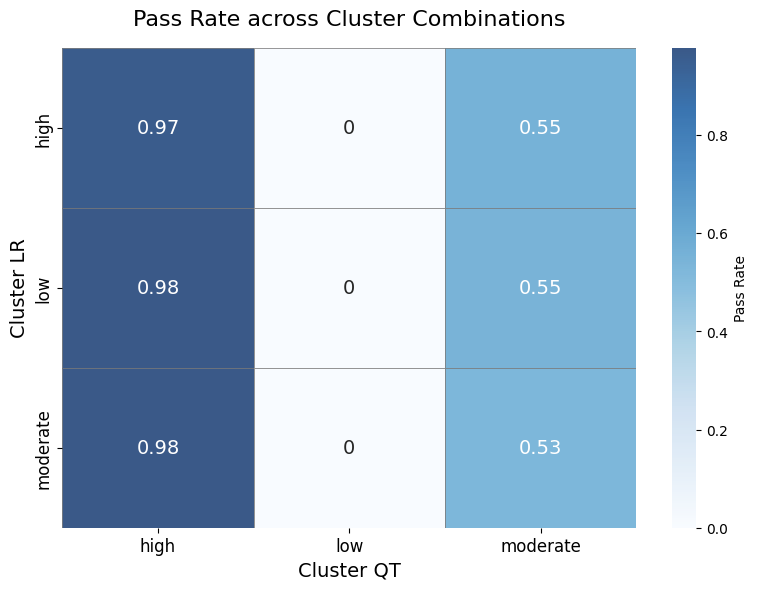

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

heatmap_data = pass_rate.pivot('cluster_lr', 'cluster_qt', 'pass_rate')

cmap = sns.color_palette("Blues", as_cmap=True)

plt.figure(figsize=(8, 6))

sns.heatmap(
    heatmap_data,
    annot=True,
    cmap=cmap,
    cbar_kws={'label': 'Pass Rate'},
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size": 14},
    alpha=0.8  # Transparency
)


plt.title('Pass Rate across Cluster Combinations', size=16, y=1.03)
plt.xlabel('Cluster QT', size=14)
plt.ylabel('Cluster LR', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()

plt.show()


Based on the table above, regardless of the engagement rate, high test/quiz performers are consistently passing. This is not surprising, since 'passing' implies grades calculated on test/quiz scores. The engagement rate doesn't seem to have much weight in influencing passing rate.

# Analysis: How This Data Might Be Useful

## High Dependency on Test Performance


####Insight:
Across all levels of learning resource engagement (cluster_lr), the pass rate is significantly high for cluster_qt 1 (which we can infer represents high test performers) and significantly low for cluster_qt 2 (likely representing low test performers).

This indicates that regardless of engagement with learning resources, test performance plays a critical role in determining success.




####Action:
While tests are vital, educational strategies might be diversified. This includes incorporating more continuous assessment techniques, project-based evaluations, or other holistic measures to gauge student understanding.



---




## Low Engagement with Resources Isn't Necessarily Detrimental:


####Insight:
The pass rates for cluster_lr 0 and cluster_lr 1 (likely representing lower and moderate engagement with learning resources) are comparable when looking at similar test performance clusters.


####Action:
This could lead to a re-evaluation of the resources provided. Are they essential? Could they be made more engaging or relevant? A feedback mechanism can be implemented to understand students' preferences and obstacles when it comes to resource engagement.




---



##High Resource Engagement Doesn't Guarantee High Test Performance:


####Insight:
Even those in the high engagement with resources cluster (cluster_lr 2) have a 0% pass rate when they are in the low test performance group (cluster_qt 2).


####Action:
It would be worth investigating the quality and relevance of the learning resources. Perhaps students are spending a lot of time on resources that aren't directly improving their test-taking abilities. There might be a need for more targeted resources or guidance on how to utilize them effectively.


---

##Consistent High Performers in Tests:


####Insight:
Cluster_qt 1 consistently shows high pass rates regardless of resource engagement. This suggests a group of students who excel in tests, irrespective of their interaction with provided resources.


####Action:
For such students, advanced or supplementary materials might be introduced to further challenge and develop their understanding.

---
##Concerning Low Performance:

####Insight:
Cluster_qt 2 consistently shows a 0% pass rate across all levels of resource engagement. This is concerning and indicates a group of students who are struggling significantly.

####Action:
An immediate intervention is required for this group. This could include remedial classes, one-on-one tutoring, counseling, or even a feedback session to understand their challenges better.